## 1-Setup, imports, helper functions

In [28]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



# Create analysis and images folders if not exist
os.makedirs("data/analysis", exist_ok=True)
os.makedirs("docs/images", exist_ok=True)

print("Folders ready ✅")


sns.set(style="whitegrid", rc={"figure.figsize": (10,5)})

# create output folders
Path("docs/images").mkdir(parents=True, exist_ok=True)
Path("data/analysis").mkdir(parents=True, exist_ok=True)

def normalize_cols(df):
    df = df.copy()
    df.columns = (
        df.columns.str.strip()
                  .str.lower()
                  .str.replace(" ", "_")
                  .str.replace(r"[^\w_]", "", regex=True)
    )
    return df

def find_date_col(df):
    # return first column name that looks like a date (name contains 'date' or dtype datetime)
    for c in df.columns:
        if "date" in c or "time" in c:
            return c
    # fallback: find any datetime dtype
    for c in df.columns:
        if np.issubdtype(df[c].dtype, np.datetime64):
            return c
    # fallback: try to parse candidate columns (common)
    candidates = ["invoice_date", "invoicedate", "order_date", "orderdate", "date"]
    for cand in candidates:
        if cand in df.columns:
            return cand
    return None

def find_revenue_col(df):
    for c in ["sales", "revenue", "amount", "total"]:
        if c in df.columns:
            return c
    # fallback if unitprice and quantity exist
    if "unitprice" in df.columns and "quantity" in df.columns:
        return None  # indicate compute via unitprice*quantity
    return None


Folders ready ✅


## 2- Load cleaned datasets

In [11]:
import pandas as pd

# Load cleaned datasets (adjust file names if different)
hr = pd.read_csv("data/cleaned/hr_clean.csv")
superstore = pd.read_csv("data/cleaned/superstore_clean.csv")
retail = pd.read_csv("data/cleaned/retail_clean.csv")

# Show first rows as tables
from IPython.display import display
display(hr.head())
display(superstore.head())
display(retail.head())



,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,AttritionFlag
0,41,1,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,80,0,8,0,1,6,4,0,5,1
1,49,0,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,80,1,10,3,3,10,7,1,7,0
2,37,1,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,80,0,7,3,3,0,0,0,0,1
3,33,0,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,80,0,8,3,3,8,7,3,0,0
4,27,0,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,80,1,6,3,3,2,2,2,2,0


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country/Region,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2020-152156,2020-11-08,2020-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2020-152156,2020-11-08,2020-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2020-138688,2020-06-12,2020-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2019-108966,2019-10-11,2019-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2019-108966,2019-10-11,2019-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [17]:
# Show column names for reference

print("HR Columns:", list(hr.columns))

print("Superstore Columns:", list(superstore.columns))


print("Retail Columns:", list(retail.columns))



HR Columns: ['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount', 'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'AttritionFlag']
Superstore Columns: ['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country/Region', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit']
Retail Columns: ['InvoiceNo', 'StockCode', 'Description', 'Quanti

## 3 - date columns are datetime

In [22]:
# Convert date columns to datetime format manually

# For Superstore
superstore['Order Date'] = pd.to_datetime(superstore['Order Date'], errors='coerce')

# For Retail
retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'], errors='coerce')

print("Superstore Order Date converted:", superstore['Order Date'].dtype)
print("Retail InvoiceDate converted:", retail['InvoiceDate'].dtype)


Superstore Order Date converted: datetime64[ns]
Retail InvoiceDate converted: datetime64[ns]


## 4- Monthly revenue (Superstore)

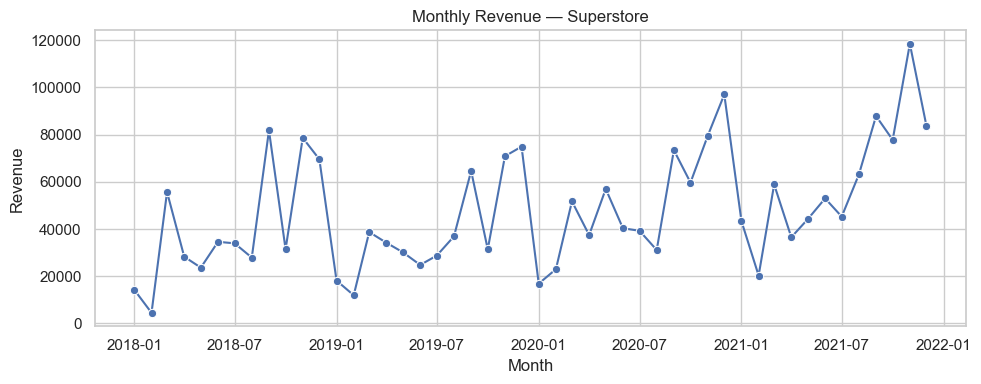

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Make sure 'Order Date' is datetime
superstore['Order Date'] = pd.to_datetime(superstore['Order Date'], errors='coerce')

# Revenue column is usually called "Sales" in Superstore
superstore['Revenue'] = superstore['Sales']

# Group by month
monthly_sales = superstore.groupby(superstore['Order Date'].dt.to_period("M"))['Revenue'].sum().reset_index()
monthly_sales['Order Date'] = monthly_sales['Order Date'].dt.to_timestamp()

# Save results
monthly_sales.to_csv("data/analysis/monthly_sales_superstore.csv", index=False)

# Plot
plt.figure(figsize=(10,4))
sns.lineplot(data=monthly_sales, x="Order Date", y="Revenue", marker="o")
plt.title("Monthly Revenue — Superstore")
plt.xlabel("Month"); plt.ylabel("Revenue")
plt.tight_layout()
plt.savefig("docs/images/monthly_revenue_superstore.png", dpi=150)
plt.show()


## 5- Monthly revenue (Retail) 

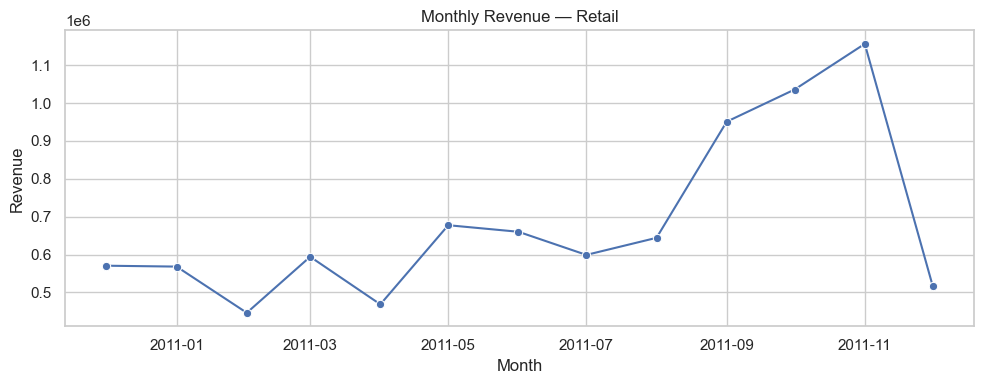

In [34]:
# Compute revenue = Quantity * UnitPrice
retail['Revenue'] = retail['Quantity'] * retail['UnitPrice']

monthly_retail = retail.groupby(retail['InvoiceDate'].dt.to_period("M"))['Revenue'].sum().reset_index()
monthly_retail['InvoiceDate'] = monthly_retail['InvoiceDate'].dt.to_timestamp()

# Save + plot
monthly_retail.to_csv("data/analysis/monthly_retail.csv", index=False)

plt.figure(figsize=(10,4))
sns.lineplot(data=monthly_retail, x="InvoiceDate", y="Revenue", marker="o")
plt.title("Monthly Revenue — Retail")
plt.xlabel("Month"); plt.ylabel("Revenue")
plt.tight_layout()
plt.savefig("docs/images/monthly_revenue_retail.png", dpi=150)
plt.show()


## 6- Top 10 products

**Superstore top 10 products**

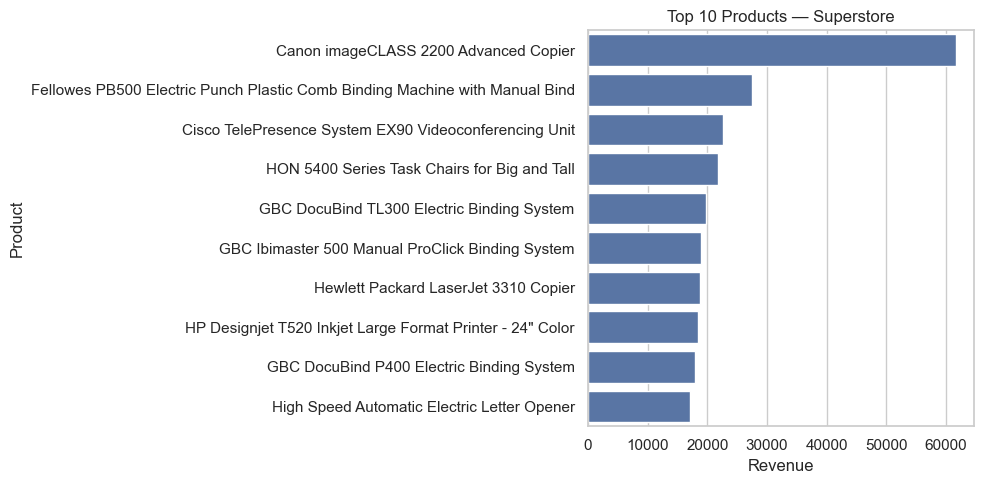

In [38]:
top_products = superstore.groupby('Product Name')['Revenue'].sum().sort_values(ascending=False).head(10)
top_products.to_csv("data/analysis/top_products_superstore.csv")

plt.figure(figsize=(10,5))
sns.barplot(x=top_products.values, y=top_products.index)
plt.title("Top 10 Products — Superstore")
plt.xlabel("Revenue"); plt.ylabel("Product")
plt.tight_layout()
plt.savefig("docs/images/top_products_superstore.png", dpi=150)
plt.show()

**Retail top 10 products**

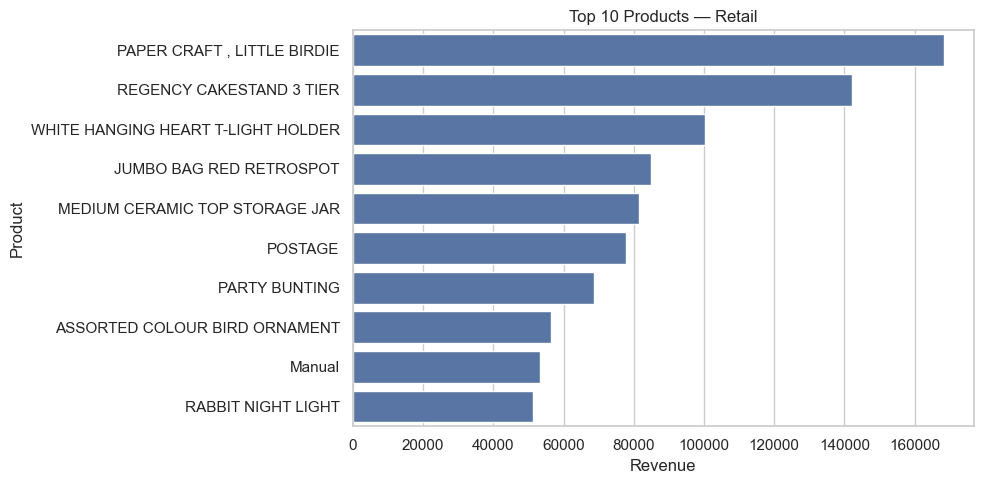

In [43]:
top_retail_products = retail.groupby('Description')['Revenue'].sum().sort_values(ascending=False).head(10)
top_retail_products.to_csv("data/analysis/top_products_retail.csv")

plt.figure(figsize=(10,5))
sns.barplot(x=top_retail_products.values, y=top_retail_products.index)
plt.title("Top 10 Products — Retail")
plt.xlabel("Revenue"); plt.ylabel("Product")
plt.tight_layout()
plt.savefig("docs/images/top_products_retail.png", dpi=150)
plt.show()

## 7-Revenue by region (Superstore)

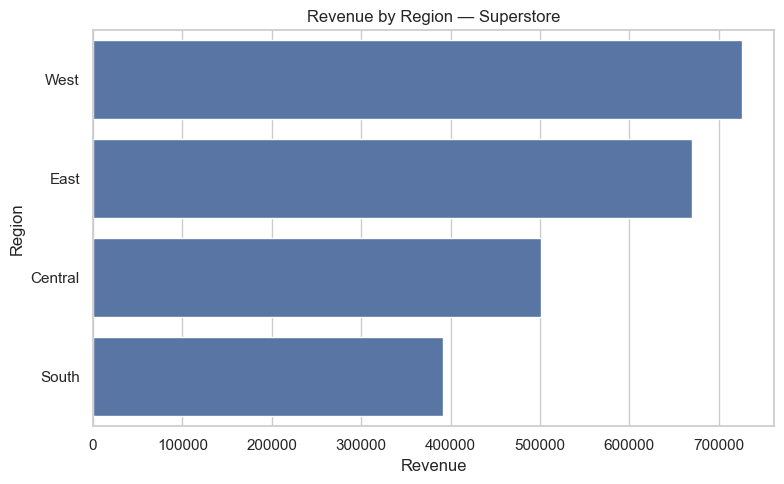

In [46]:
rev_by_region = superstore.groupby('Region')['Revenue'].sum().sort_values(ascending=False)
rev_by_region.to_csv("data/analysis/revenue_by_region.csv")

plt.figure(figsize=(8,5))
sns.barplot(x=rev_by_region.values, y=rev_by_region.index)
plt.title("Revenue by Region — Superstore")
plt.xlabel("Revenue"); plt.ylabel("Region")
plt.tight_layout()
plt.savefig("docs/images/revenue_by_region.png", dpi=150)
plt.show()


## 8- Customer behavior (Retail)

Retail Repeat Purchase Rate: 65.58%


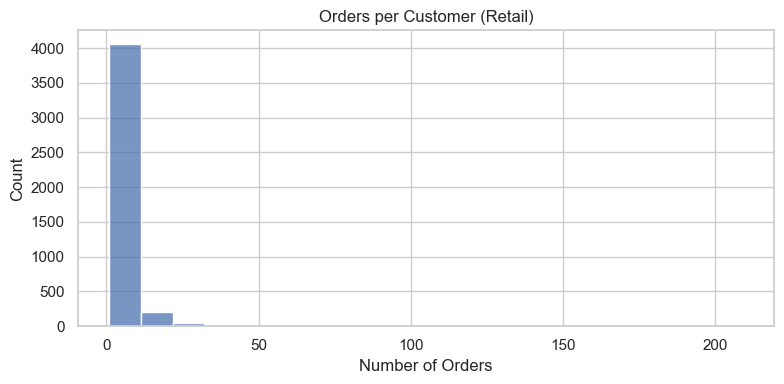

In [53]:
# Customer summary
cust_tx = retail.groupby('CustomerID').agg(
    orders=('InvoiceNo','nunique'),
    total_spent=('Revenue','sum'),
    last_purchase=('InvoiceDate','max')
).reset_index()

cust_tx.to_csv("data/analysis/customer_summary_retail.csv", index=False)

# Repeat purchase rate
repeat_rate = (cust_tx['orders'] > 1).mean()
print(f"Retail Repeat Purchase Rate: {repeat_rate:.2%}")

# Plot orders distribution
plt.figure(figsize=(8,4))
sns.histplot(cust_tx['orders'], bins=20)
plt.title("Orders per Customer (Retail)")
plt.xlabel("Number of Orders")
plt.tight_layout()
plt.savefig("docs/images/customer_orders_distribution.png", dpi=150)
plt.show()


## 9 - HR Analysis (Attrition & Satisfaction)

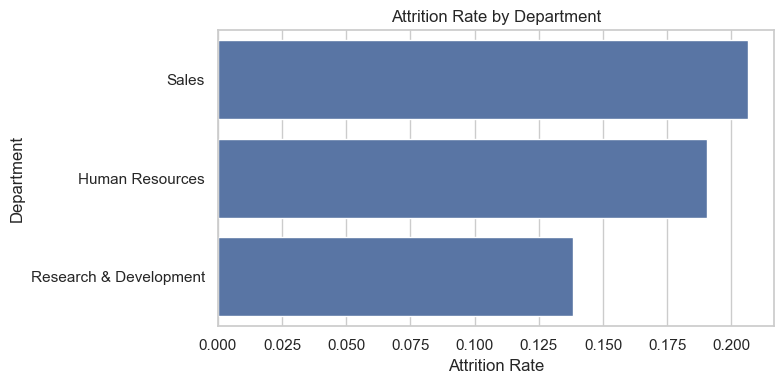

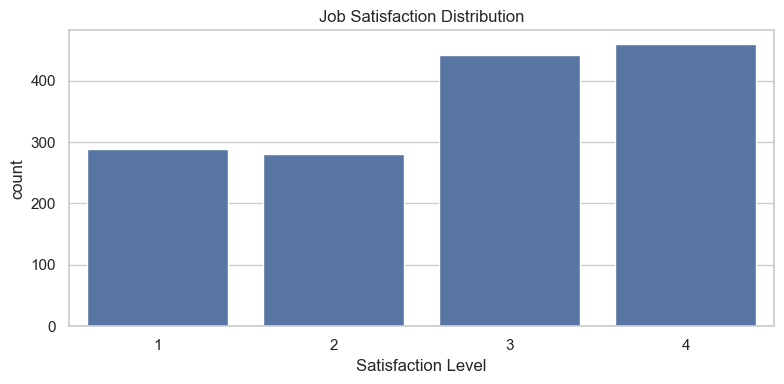

In [57]:
# Attrition by Department
attr_by_dept = hr.groupby('Department')['AttritionFlag'].mean().sort_values(ascending=False)
attr_by_dept.to_csv("data/analysis/attrition_by_dept.csv")

plt.figure(figsize=(8,4))
sns.barplot(x=attr_by_dept.values, y=attr_by_dept.index)
plt.title("Attrition Rate by Department")
plt.xlabel("Attrition Rate")
plt.tight_layout()
plt.savefig("docs/images/attrition_by_dept.png", dpi=150)
plt.show()

# Job Satisfaction (if column exists)
if 'JobSatisfaction' in hr.columns:
    plt.figure(figsize=(8,4))
    sns.countplot(x=hr['JobSatisfaction'])
    plt.title("Job Satisfaction Distribution")
    plt.xlabel("Satisfaction Level")
    plt.tight_layout()
    plt.savefig("docs/images/job_satisfaction_distribution.png", dpi=150)
    plt.show()


## Summary of saved outputs

In [61]:
print(" Analysis complete. Files saved:")

print("\nData (CSV) in data/analysis/:")
for f in os.listdir("data/analysis"):
    print(" -", f)

print("\nCharts (PNG) in docs/images/:")
for f in os.listdir("docs/images"):
    print(" -", f)


 Analysis complete. Files saved:

Data (CSV) in data/analysis/:
 - attrition_by_dept.csv
 - revenue_by_region.csv
 - monthly_retail.csv
 - customer_summary_retail.csv
 - monthly_sales_superstore.csv
 - top_products_superstore.csv
 - top_products_retail.csv

Charts (PNG) in docs/images/:
 - top_products_superstore.png
 - top_products_retail.png
 - monthly_revenue_superstore.png
 - customer_orders_distribution.png
 - job_satisfaction_distribution.png
 - revenue_by_region.png
 - monthly_revenue_retail.png
 - attrition_by_dept.png
